In [2]:
import pandas as pd 
#import geopandas as gpd 
import matplotlib.pyplot as plt
from wbpyplot import wb_plot
# Optional: package not installed in this environment; guard import
try:
    import acled_conflict_analysis  # noqa: F401
except Exception:
    pass

In [3]:
acled = pd.read_csv('../data/conflict/acled_data_all_10022025.csv')

In [4]:
countries_of_interest = [
    "Afghanistan","Pakistan","Algeria","Morocco","Libya","Yemen","Iran", "Iraq",
    "Syria","Egypt","Lebanon","Djibouti","United Arab Emirates","Jordan","Palestine",
    "Oman", "Qatar", "Saudi Arabia", "Kuwait", "Tunisia", "Bahrain"]

In [5]:
protests = acled[acled['event_type'] == 'Protests']
mena_protests = protests[protests['country'].isin(countries_of_interest)]
mena_protests['event_date'] = pd.to_datetime(mena_protests['event_date'])
mena_protests = mena_protests[mena_protests['event_date'].dt.year >= 2005]

/var/folders/gs/_227cnyd0pq1fr817_0jbcyw0000gp/T/ipykernel_60606/515035799.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mena_protests['event_date'] = pd.to_datetime(mena_protests['event_date'])


In [13]:
wb_regions = pd.read_csv('../../../ssarva/MENAAP-Conflict-Analysis/data/worldbank_regions_iso3_exclusions.csv')

In [15]:
wb_regions[['country_code', 'region_code']]

,country_code,region_code
0,ASM,EAS
1,AUS,EAS
2,BRN,EAS
3,CHN,EAS
4,FJI,EAS
...,...,...
208,TZA,SSF
209,UGA,SSF
210,ZAF,SSF
211,ZMB,SSF


In [11]:
protests['country'].nunique()

230

In [6]:
mena_protests_sub_event = mena_protests.groupby(['country','sub_event_type', pd.Grouper(key='event_date', freq='YS')]).size().reset_index(name='nrEvents')

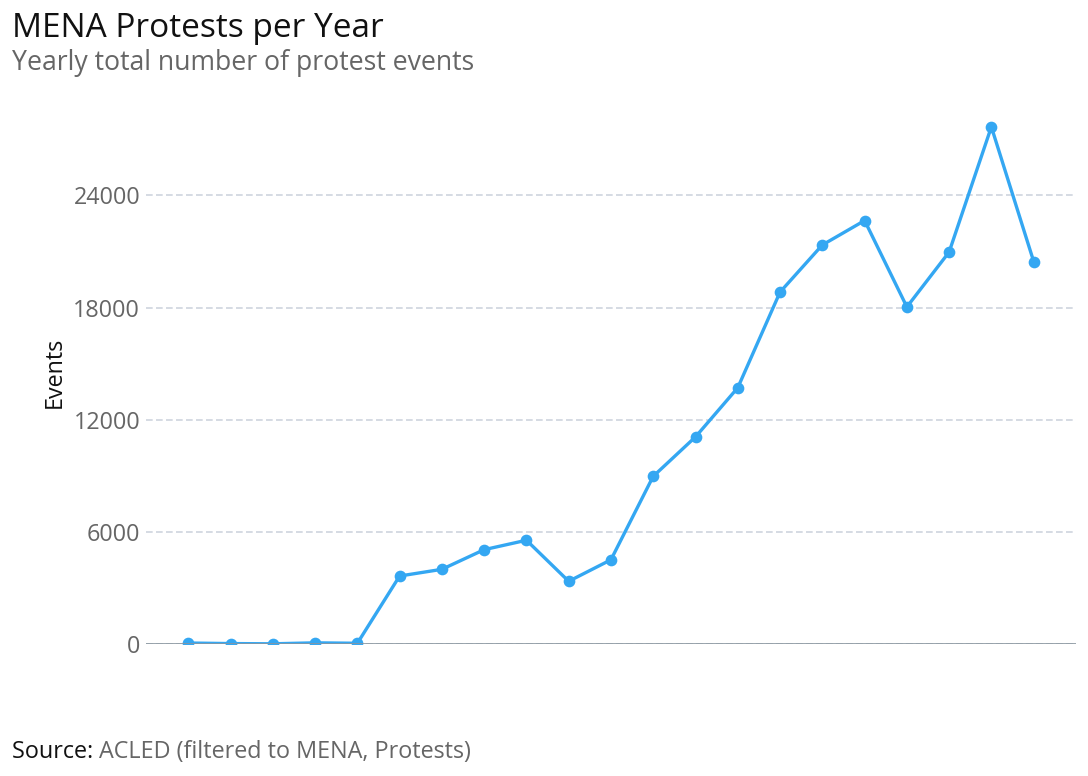

In [10]:
# Yearly MENA protest counts and WB-styled line plot
# Build yearly totals (already filtered to MENA and year >= 2005 earlier)
df_yearly = (
    mena_protests
    .groupby(pd.Grouper(key='event_date', freq='YS'))
    .size()
    .reset_index(name='nrEvents')
    .sort_values('event_date')
)

@wb_plot(
    title="MENA Protests per Year",
    subtitle="Yearly total number of protest events",
    note=[("Source:", "ACLED (filtered to MENA, Protests)")],
)
def plot_mena_yearly(axs):
    ax = axs[0] if isinstance(axs, (list, tuple)) else axs
    ax.plot(df_yearly['event_date'], df_yearly['nrEvents'], marker='o', linewidth=2, label='Total protests')
    ax.set_ylabel("Events")
    ax.legend()

plot_mena_yearly()

In [12]:
df_yearly_agg

,event_date,nrEvents,fatalities
0,2005-01-01,52,1
1,2006-01-01,23,0
2,2007-01-01,11,0
3,2008-01-01,62,2
4,2009-01-01,39,0
5,2010-01-01,3637,15
6,2011-01-01,3995,889
7,2012-01-01,5046,34
8,2013-01-01,5552,588
9,2014-01-01,3355,13


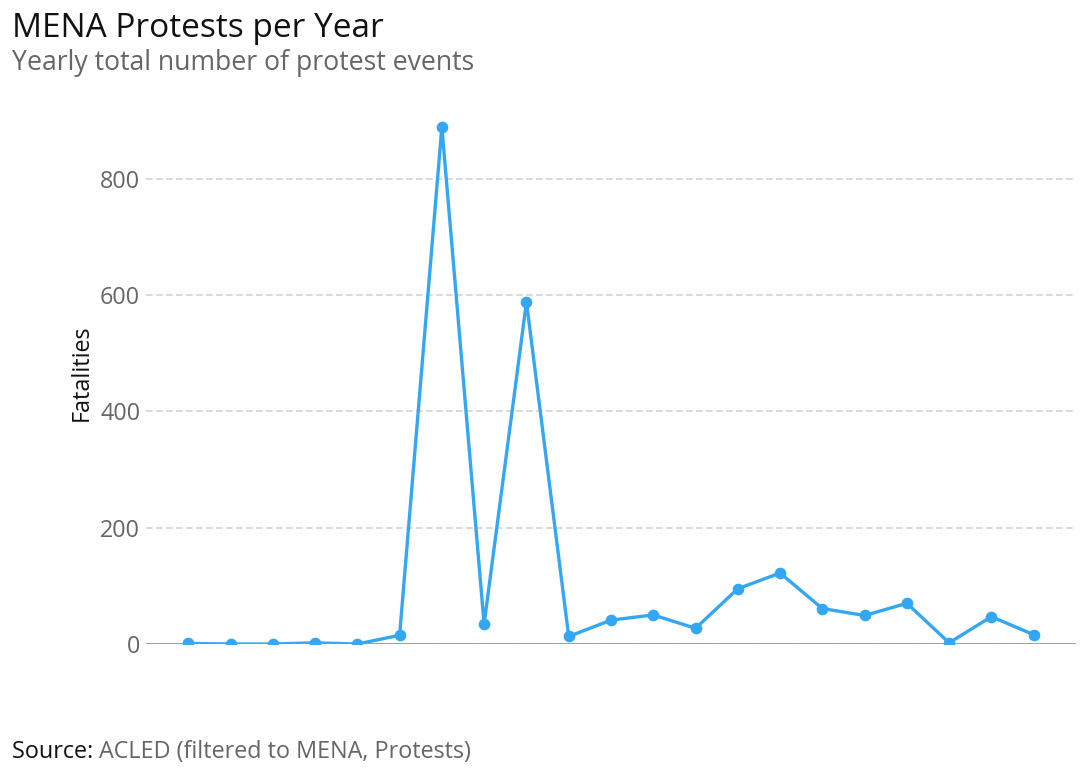

In [13]:
# Yearly aggregation: number of events (size) and fatalities (sum)
df_yearly_agg = (
    mena_protests
    .groupby(pd.Grouper(key='event_date', freq='YS'))
    .agg(
        nrEvents=('fatalities', 'size'),
        fatalities=('fatalities', 'sum'),
    )
    .reset_index()
    .sort_values('event_date')
)



@wb_plot(
    title="MENA Protests per Year",
    subtitle="Yearly total number of protest events",
    note=[("Source:", "ACLED (filtered to MENA, Protests)")],
)
def plot_mena_yearly(axs):
    ax = axs[0] if isinstance(axs, (list, tuple)) else axs
    ax.plot(df_yearly_agg['event_date'], df_yearly_agg['fatalities'], marker='o', linewidth=2, label='Total protests')
    ax.set_ylabel("Fatalities")
    ax.legend()

plot_mena_yearly()

In [15]:
mena_protests.to_csv('../data/conflict/mena_protests.csv', index=False)

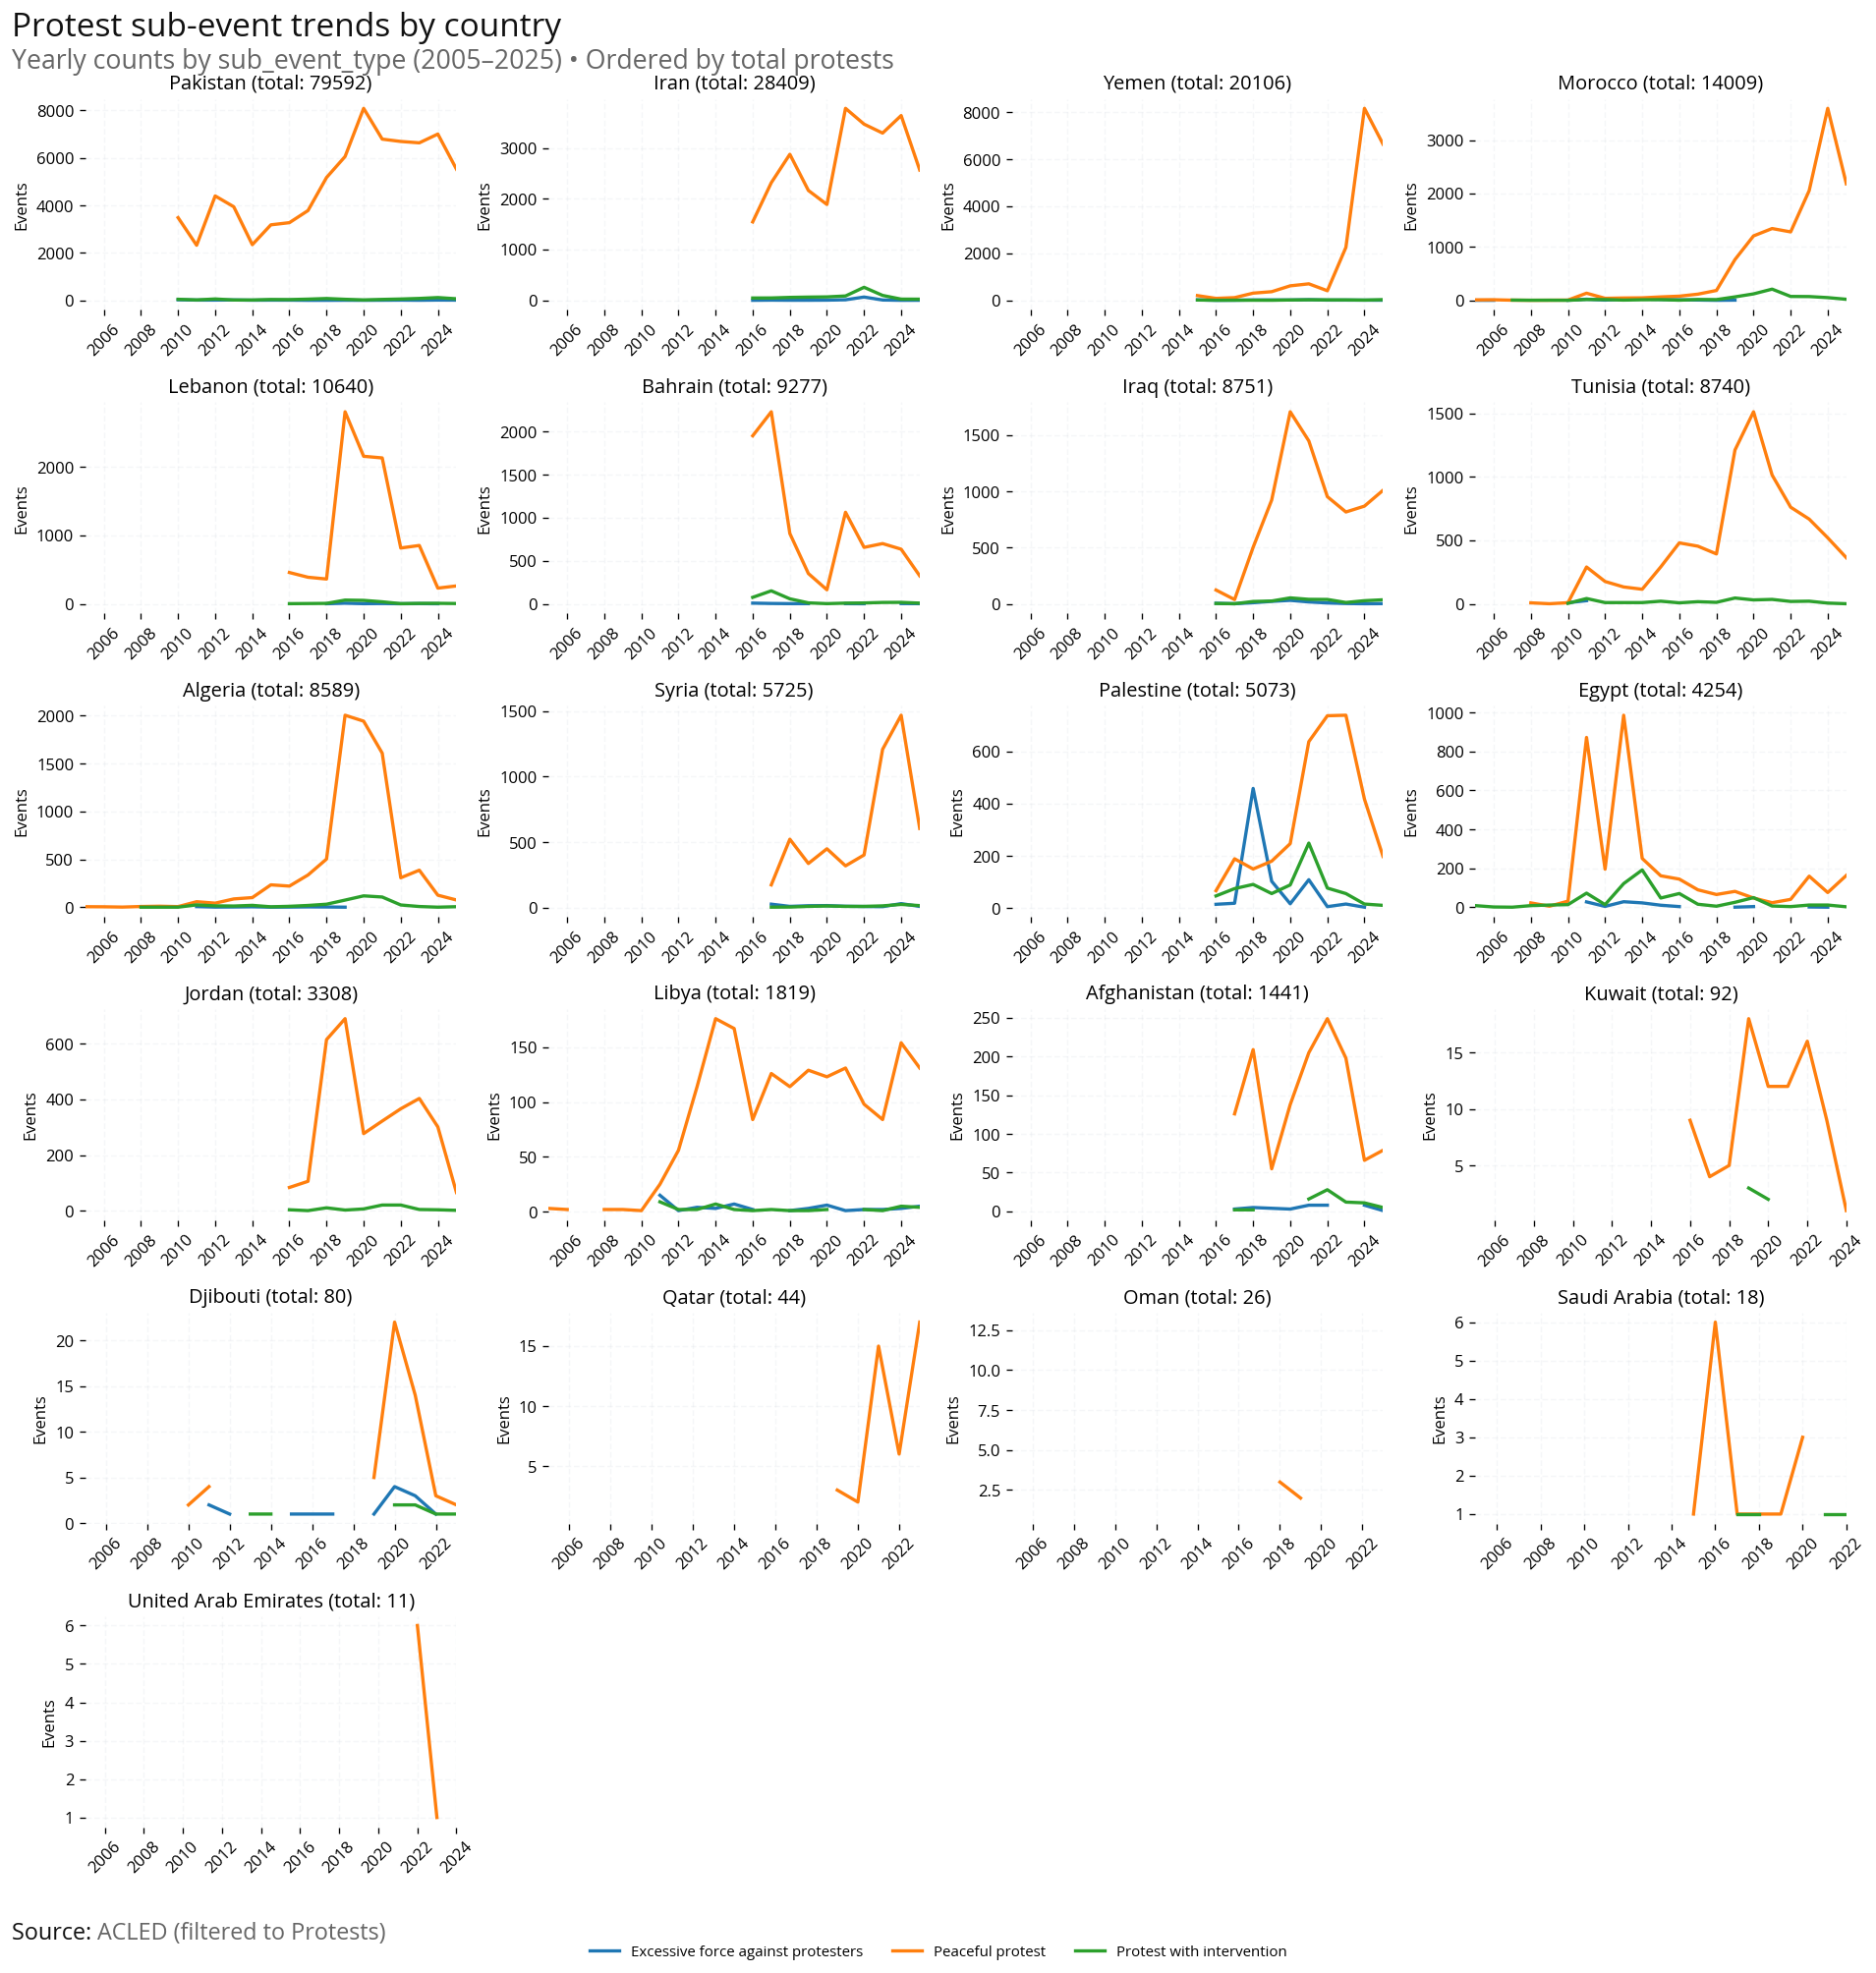

In [68]:
# Subplots: one panel per country, lines per sub_event_type with consistent colors
from wbpyplot import wb_plot
import seaborn as sns
import numpy as np

# Ensure consistent colors for sub_event types across all charts
sub_event_levels = sorted(mena_protests_sub_event['sub_event_type'].dropna().unique())
# Choose a palette large enough for all levels
base_palette = 'tab20' if len(sub_event_levels) > 10 else 'tab10'
colors = sns.color_palette(base_palette, n_colors=max(len(sub_event_levels), 10))
SUB_EVENT_COLORS = {lvl: colors[i % len(colors)] for i, lvl in enumerate(sub_event_levels)}


START_YEAR = 2005
START_TS = pd.Timestamp(f"{START_YEAR}-01-01")


def _plot_country_panel(ax, df_country, indicator_colors):
    # Build a complete yearly index from 2000 to the country's last year
    if df_country.empty:
        ax.set_axis_off()
        return
    last_ts = df_country['event_date'].max()
    full_idx = pd.date_range(start=START_TS, end=last_ts, freq='YS')

    # Pivot to wide and reindex to full range; keep NaN so gaps remain blank
    wide = (
        df_country
        .pivot_table(index='event_date', columns='sub_event_type', values='nrEvents', aggfunc='sum')
        .sort_index()
        .reindex(full_idx)
    )

    for col in sub_event_levels:
        if col in wide.columns:
            ax.plot(wide.index, wide[col], label=col, color=indicator_colors[col], linewidth=2)

    ax.grid(True, alpha=0.2)
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlim([START_TS, last_ts])


def plot_mena_protests_country_subplots(df, countries=None, ncols=4, top_n=None):
    df = df.copy()
    # Start from 2000; leave missing years as blank in plots
    df = df[df['event_date'] >= START_TS]

    # Order countries by total protest counts (descending) using filtered data
    country_totals = (
        df.groupby('country', dropna=True)['nrEvents']
          .sum()
          .sort_values(ascending=False)
    )
    all_countries_ordered = country_totals.index.tolist()

    if countries is None:
        countries = all_countries_ordered
    else:
        # Keep only requested countries, but ordered by totals
        requested = set(countries)
        countries = [c for c in all_countries_ordered if c in requested]

    if top_n is not None:
        countries = countries[:top_n]

    n = len(countries)
    if n == 0:
        print("No matching countries to plot.")
        return

    ncols_local = max(1, int(ncols))
    nrows = int(np.ceil(n / ncols_local))

    title = "Protest sub-event trends by country"
    # Determine title range from filtered data
    if df['event_date'].empty:
        date_min = START_TS
        date_max = START_TS
    else:
        date_min = df['event_date'].min()
        date_max = df['event_date'].max()
    subtitle = f"Yearly counts by sub_event_type ({START_YEAR}–{date_max:%Y}) • Ordered by total protests"

    @wb_plot(
        title=title,
        subtitle=subtitle,
        note=[("Source:", "ACLED (filtered to Protests)")],
    )
    def _draw(axs):
        # Use the figure provided by decorator, re-create our grid
        fig = axs[0].figure if isinstance(axs, (list, tuple, np.ndarray)) else plt.gcf()
        fig.clf()
        fig.set_size_inches(max(12, 4 * ncols_local), max(8, 2.8 * nrows))
        axes = fig.subplots(nrows, ncols_local).reshape(-1)

        for i, country in enumerate(countries):
            ax = axes[i]
            df_country = df[df['country'] == country]
            if df_country.empty:
                ax.set_axis_off()
                continue
            _plot_country_panel(ax, df_country, SUB_EVENT_COLORS)
            total = int(country_totals.get(country, 0))
            ax.set_title(f"{country} (total: {total})")
            ax.set_ylabel('Events')

        # Hide any extra axes
        for j in range(len(countries), len(axes)):
            axes[j].set_visible(False)

        # Shared legend at bottom
        handles = [plt.Line2D([0], [0], color=SUB_EVENT_COLORS[l], lw=2, label=l) for l in sub_event_levels]
        fig.legend(handles=handles, labels=sub_event_levels, loc='lower center', ncol=min(4, len(sub_event_levels)), fontsize=9)
        plt.tight_layout(rect=[0, 0.08, 1, 1])

    _draw()

# Run for your MENA list, ordered by total protests
display_cols = 4
plot_mena_protests_country_subplots(mena_protests_sub_event, countries=countries_of_interest, ncols=display_cols)